# Baynes climatology

In [104]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from matplotlib.patches import Rectangle
from itertools import repeat, chain
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.signal import butter, lfilter
from salishsea_tools import places, utilities, viz_tools
from timeseries_extras import load_hindcast_timeseries_location

%matplotlib inline

***

## Load results records
Define paths and slices

In [3]:
# Connect HRDPS object to ERDDAP source and specify date and location parameters
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
path_NEMO = '/results/SalishSea/hindcast.201812'
path_NEMO_annex = '/results2/SalishSea/hindcast.201812_annex'
daterange = [datetime(2014, 9, 12), datetime(2019, 2, 19)]
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']

Load HRDPS at Sentry Shoal from ERDDAP

In [7]:
# Load netCDF data from ERDDAP in 6 month chunks
time = np.empty(0)
v_raw = np.empty(0)
bar = utilities.statusbar('Loading ...')
for interval in bar(range(int(np.diff(daterange)[0].days/180))):
    dateslice = slice(*[daterange[0] + timedelta(days=i*180) for i in [interval, interval+1]])
    time = np.concatenate((time, HRDPS.time.sel(time=dateslice).values.astype('datetime64[s]').astype(datetime)))
    v_raw = np.concatenate((v_raw, HRDPS.v_wind.sel(time=dateslice).isel(gridY=j, gridX=i).values))

# Filter HRDPS record
fs = 1 / 3600
cutoff = 1 / 86400 / 7
v_filt = lfilter(*butter(2, cutoff / fs / 0.5, btype='lowpass'), v_raw)

# Make HRDPS dict
HRDPS = {'time': time, 'v_raw': v_raw, 'v_filt': v_filt}

Loading ... 100% (9 of 9) |#############################################################################|Time: 0:03:38


Load SalishSeaCast results

**Note** *This will take a while, best to run in a* `tmux` *session on Salish*

In [ ]:
# Load surface tracer timeseries at Hornby and Qualicum (from Salish command line)
locs = {'Hornby': (52, 312, 0), 'Qualicum': (66, 257, 0)}
daterange = ['2015 Jan 1', '2018 Dec 31']
loadpath = '/results/SalishSea/hindcast.201812'
loadpath_cutoff = '/results2/SalishSea/hindcast.201812_annex'
writepath = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data'

load_hindcast_timeseries_location(
    ['tracer20m'], locs, daterange, loadpath, writepath, ftype='mtrc_T',
    date_cutoff='2016 Nov 21', loadpath_cutoff=loadpath_cutoff,
)

In [233]:
# Load saved timeseries from xarry files
prefix = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/hindcast201812_20150101_20181231_'
NEMO = {}
for key in ['Hornby', 'Qualicum']:
    NEMO[key] = xr.open_dataset(prefix + key + '_tracer20m.nc')

***

## Timeseries

Generic function to plot HRDPS and NEMO timeseries

In [279]:
def plot_ts(fig, ax, HRDPS, NEMO, window, windtype='raw', tickfreq='Month', datefmt='%b'):
    """Plot HRDPS and NEMO timeseries during a given time window
    """
    
    # Make axes
    ax_right = ax.twinx()
    
    # Plot data
    index = [abs(HRDPS['time'] - date).argmin() for date in window]
    for attr, color in zip(['fill_between', 'plot'], ['lightgray', 'gray']):
        getattr(ax, attr)(*[HRDPS[var][slice(*index)] for var in ['time', f'v_{windtype}']], color=color)
    for key in NEMO:
        ax_right.plot(*[NEMO[key][var].sel(time=slice(*window)) for var in ['time', 'tracer20m']], label=key)
    
    # Formatting
    for axis, ylim, ylabel in zip([ax, ax_right], [[-10, 10], [-0.05, 1.05]], ['Longshore wind [m/s]', 'Tracer']):
        axis.set_ylim(ylim)
        axis.set_ylabel(ylabel)
    ax.set_xlim(window)
    ax.xaxis.set_major_locator(getattr(mdates, f'{tickfreq}Locator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(datefmt))
    
    return ax_right

Plot the entire record from 2015 through 2018

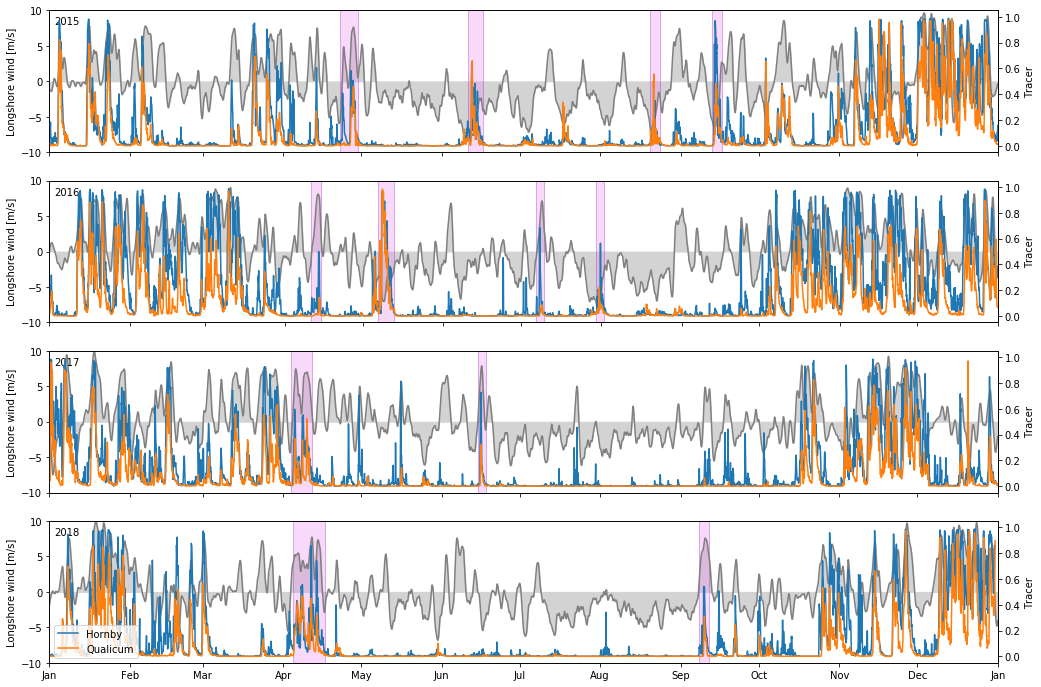

In [383]:
# Plot HRDPS and hindcast timeseries
fig, axs = plt.subplots(4, 1, figsize=(17, 12))
for ax, year in zip(axs, range(2015, 2019)):
    window = [datetime(y, 1, 1) for y in [year, year + 1]]
    ax_right = plot_ts(fig, ax, HRDPS, NEMO, window, windtype='filt')
    for event in events:
        window = [mdates.date2num(date) for date in event['window']]
        ax.add_patch(Rectangle((window[0], -10), np.diff(window)[0], 20, fc='violet', ec='darkviolet', alpha=0.3))
    ax.text(0.005, 0.9, str(year), transform=ax.transAxes)
    if year < 2018:
        ax.xaxis.set_ticklabels('')

ax_right.legend(loc=3)
plt.show()

***

## Specific upwelling events

Shaded in violet above.

In [382]:
# Upwelling event date windows
events = [
    {'window': ['2015 Apr 23', '2015 Apr 30'], 'hours': [22, 100, 112, 122]},
    {'window': ['2015 Jun 11', '2015 Jun 17'], 'hours': [36, 42, 60, 90]},
    {'window': ['2015 Aug 20', '2015 Aug 24'], 'hours': [32, 38, 44, 50]},
    {'window': ['2015 Sep 13', '2015 Sep 17'], 'hours': [18, 30, 42, 54]},
    {'window': ['2016 Apr 11', '2016 Apr 15'], 'hours': [50, 60, 70, 80]},
    {'window': ['2016 May 07', '2016 May 13'], 'hours': [30, 45, 60, 75]},
    {'window': ['2016 Jul 07', '2016 Jul 10'], 'hours': [20, 30, 40, 50]},
    {'window': ['2016 Jul 30', '2016 Aug 02'], 'hours': [20, 30, 40, 50]},
    {'window': ['2017 Apr 04', '2017 Apr 12'], 'hours': [35, 100, 110, 147]},
    {'window': ['2017 Jun 15', '2017 Jun 18'], 'hours': [20, 26, 32, 38]},
    {'window': ['2018 Apr 05', '2018 Apr 17'], 'hours': [30, 80, 162, 215]},
    {'window': ['2018 Sep 08', '2018 Sep 12'], 'hours': [30, 40, 50, 60]},
]
for event in events:
    event.update({'window': [parse(date) for date in event['window']]})

Plot events

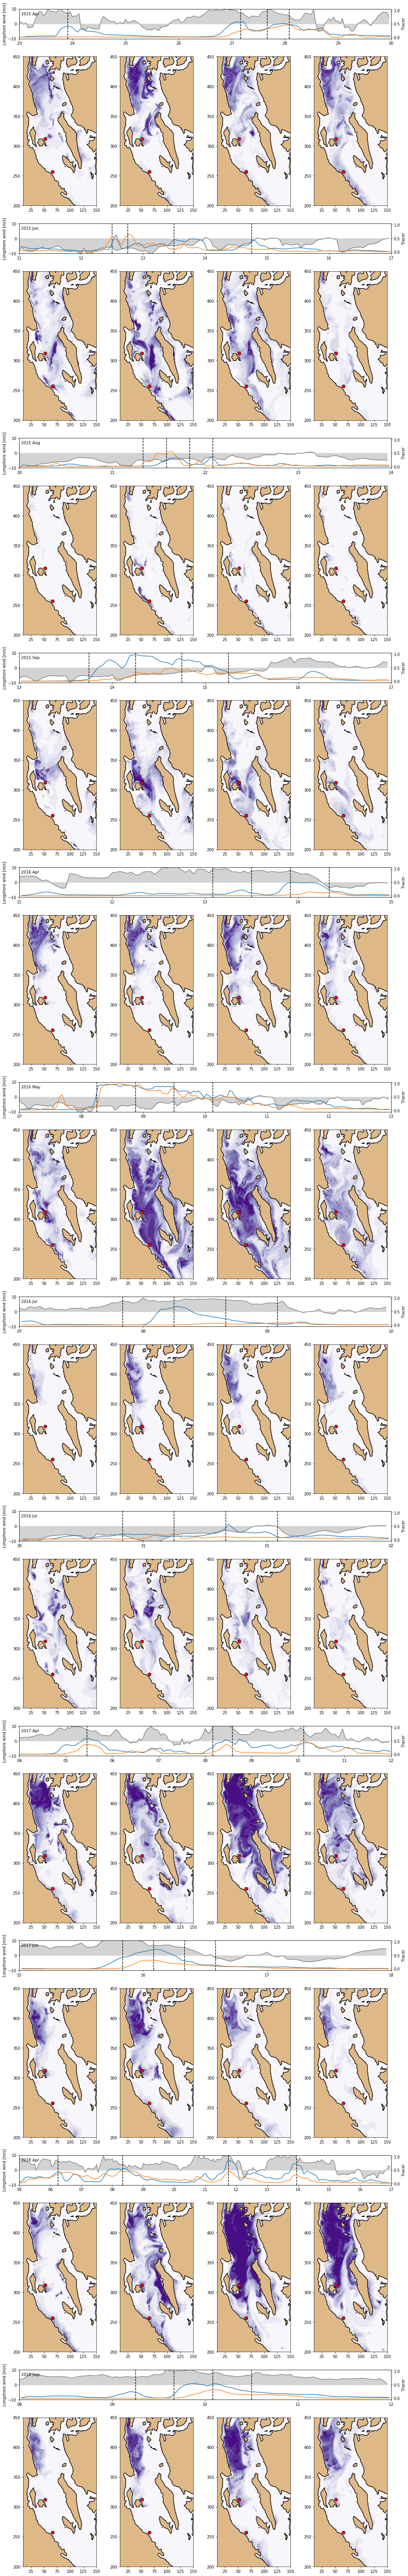

In [384]:
# Make figure layout
n_events = len(events)
fig = plt.figure(figsize=(17, n_events * 10))
height_ratios = list(chain(*repeat([1, 5], n_events)))
gs = plt.GridSpec(n_events * 2, 4, height_ratios=height_ratios)
xrange = [100, 398]
yrange = [300, 898]

# Loop though event windows
for row, event in zip(range(0, n_events * 2, 2), events):
    
    # Plot HRDPS data
    ax = fig.add_subplot(gs[row, :])
    ax_right = plot_ts(fig, ax, HRDPS, NEMO, event['window'], tickfreq='Day', datefmt='%d',)
    ax.text(0.005, 0.8, event['window'][0].strftime('%Y %b'), transform=ax.transAxes)
    
    # Loop through individual dates
    for col, hour in zip(range(4), event['hours']):
        
        # Extract NEMO data
        date = event['window'][0] + timedelta(hours=hour)
        datestr = date.strftime('%Y%m%d')
        if date.year > 2016:
            path = path_NEMO_annex
        else:
            path = path_NEMO
        fn = os.path.join(path, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_mtrc_T.nc')
        data = xr.open_dataset(fn).sel(time_counter=date, method='nearest')
        
        # Plot NEMO data
        ax_map = fig.add_subplot(gs[row+1, col])
        c = ax_map.contourf(data.x, data.y, data.tracer20m[0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'), extend='both')
        ax_map.contourf(mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='Burlywood')
        ax_map.contour(mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
        ax_map.plot(52, 312, 'ko', markerfacecolor='r', markersize=8)
        ax_map.plot(66, 257, 'ko', markerfacecolor='r', markersize=8)
        ax_map.set_xlim([10, 150])
        ax_map.set_ylim([200, 450])
        viz_tools.set_aspect(ax_map)
        
        # Mark date on HRDPS record
        ax.plot([date, date], [-10, 10], 'k--')